# Bayesian Assignment of State

In [1]:
import os
import numpy as np 
import pandas as pd
import arviz as az
import warnings
import sys
sys.path.append("..")
sys.path.append("../../spc_utils")
import spc_os
import pickle
import cellbell
import seaborn as sns
import cellbell
import matplotlib.pyplot as plt
from scipy.stats import halfcauchy, skewnorm, norm
from src.visualization.handle_data import combine_posterior_variables
from src.features.build_features import get_significant
#cpu or cuda
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float64'
import pymc3 as pm
RANDOM_SEED = 281090
warnings.filterwarnings("ignore")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/bayesian/'
reports_dir = '../reports/'

In [3]:
%mkdir ../models/bayesian

mkdir: cannot create directory ‘../models/bayesian’: File exists


In [4]:
with open('../data/aa_resid_dic.pkl', 'rb') as my_file:
    aa_dic = pickle.load(my_file)

## Set-up parameters

In [5]:
method = 'sparta_plus' # sparta_plus or ppm
nucleus = 'N' # CA C CB N
data_size = 1000  # 70000 max data_size
model_name = 'skew_model'
infer = True
critique = True

## Load and prepare data

Mask according to nuclei present in all 3 experimental states. Sample part of the data and select the nucleus.

In [6]:
df_diff = pd.read_pickle(processed_data_dir + 'diff_CS.pkl')

In [7]:
mask = df_diff.dropna(axis=1).columns

In [8]:
df_diff = df_diff.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

In [9]:
df_exp_o = pd.read_pickle(processed_data_dir + 'open_CS.pkl')

In [10]:
df_exp_o = df_exp_o.loc[:, mask].xs(nucleus, level='nuclei', axis=1)

In [11]:
df_3fb5 = pd.read_pickle(processed_data_dir +
                         f'3FB5_lb/CS_{method}_3FB5_lb.pkl')

In [12]:
df_3fb5 = df_3fb5.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_3fb5 = df_3fb5.xs(nucleus, level='nuclei', axis=1)

In [13]:
df_5vk6 = pd.read_pickle(processed_data_dir +
                         f'5VK6_lb/CS_{method}_5VK6_lb.pkl')

In [14]:
df_5vk6 = df_5vk6.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vk6 = df_5vk6.xs(nucleus, level='nuclei', axis=1)

In [15]:
df_5vkh = pd.read_pickle(processed_data_dir +
                         f'5VKH_lb/CS_{method}_5VKH_lb.pkl')

In [16]:
df_5vkh = df_5vkh.loc[:, mask].sample(data_size,
                                      random_state=RANDOM_SEED)
df_5vkh = df_5vkh.xs(nucleus, level='nuclei', axis=1)

In [17]:
coords = {
    'resid': [aa_dic[res] + str(res) for res in df_3fb5.columns],
    'step': df_3fb5.index
}

## Study Data

Some notes on CA:
+ Fast exchange: 33,38, 71, 85, 107
+ One SU different: 61
+ Assymettrical subunits: 44, 51
+ Change during trajectory: 69
+ Homogeneous: Rest

Some notes on N:
+

### Histograms

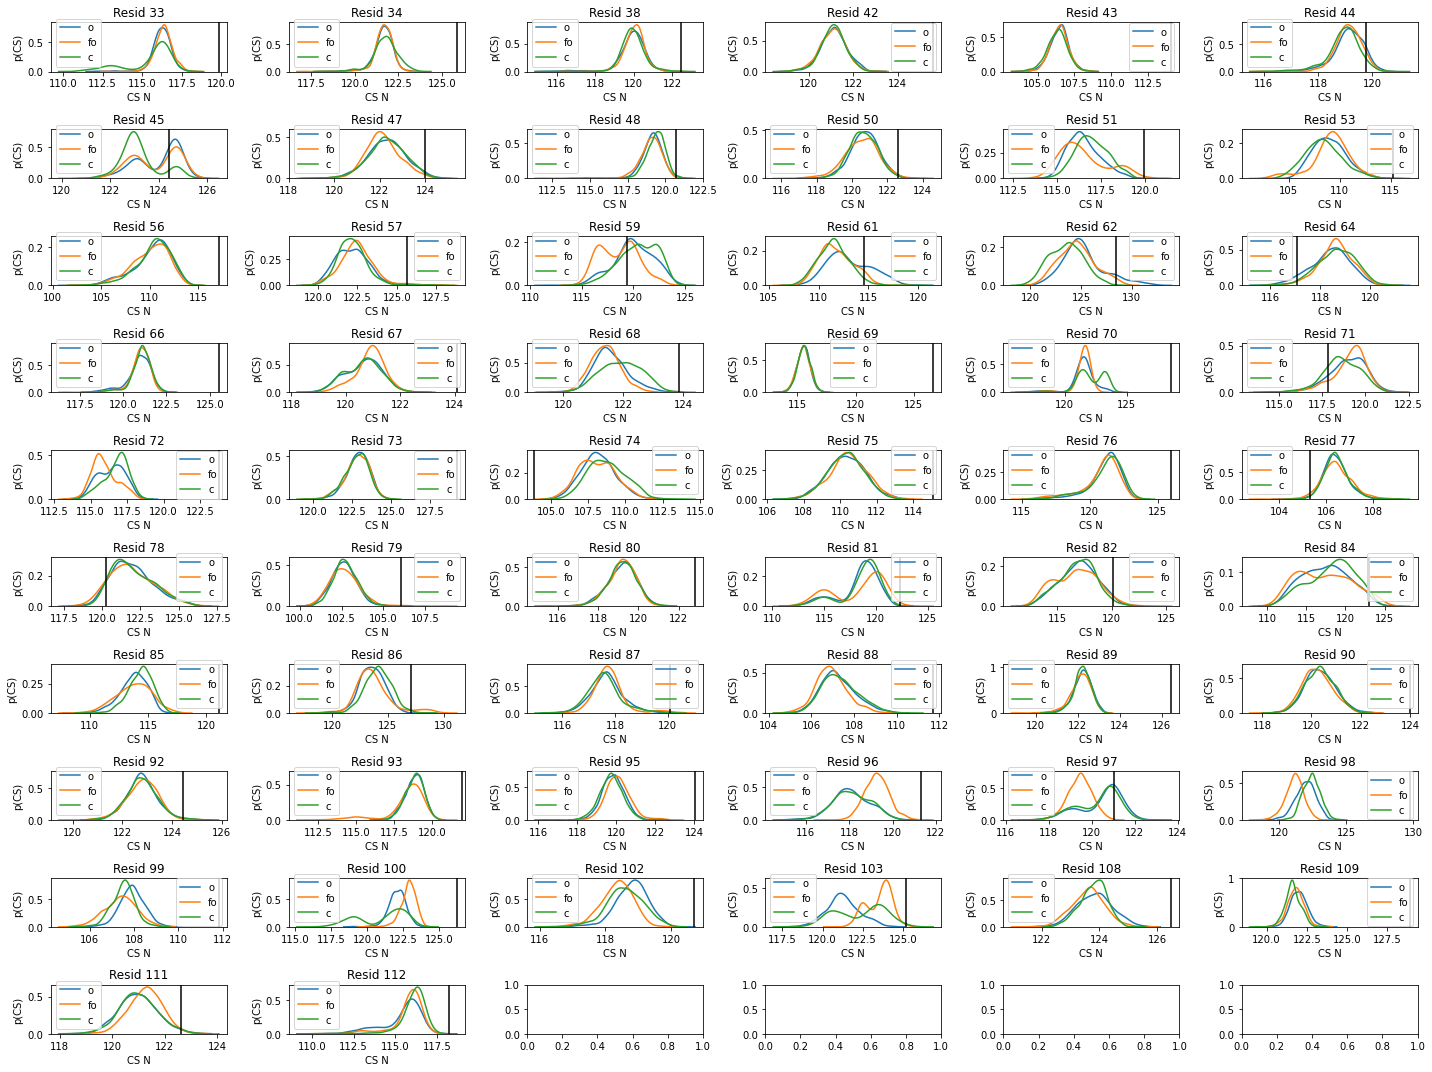

In [18]:
fig, ax = plt.subplots(df_3fb5.shape[1] // 6 + 1, 6, figsize=(20, 15))
ax = ax.flatten()
for i, resid in enumerate(df_3fb5):
    sns.kdeplot(df_3fb5[resid], ax=ax[i], label='o')
    sns.kdeplot(df_5vk6[resid], ax=ax[i], label='fo')
    sns.kdeplot(df_5vkh[resid], ax=ax[i], label='c')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_xlabel(f'CS {nucleus}')
    ax[i].set_ylabel('p(CS)')
    ax[i].axvline(x=df_exp_o[resid][0], c="black")
    ax[i].legend()
fig.tight_layout()
fig.savefig(reports_dir + f'hist_{method}_{nucleus}.png')

### Time series

#### Closed

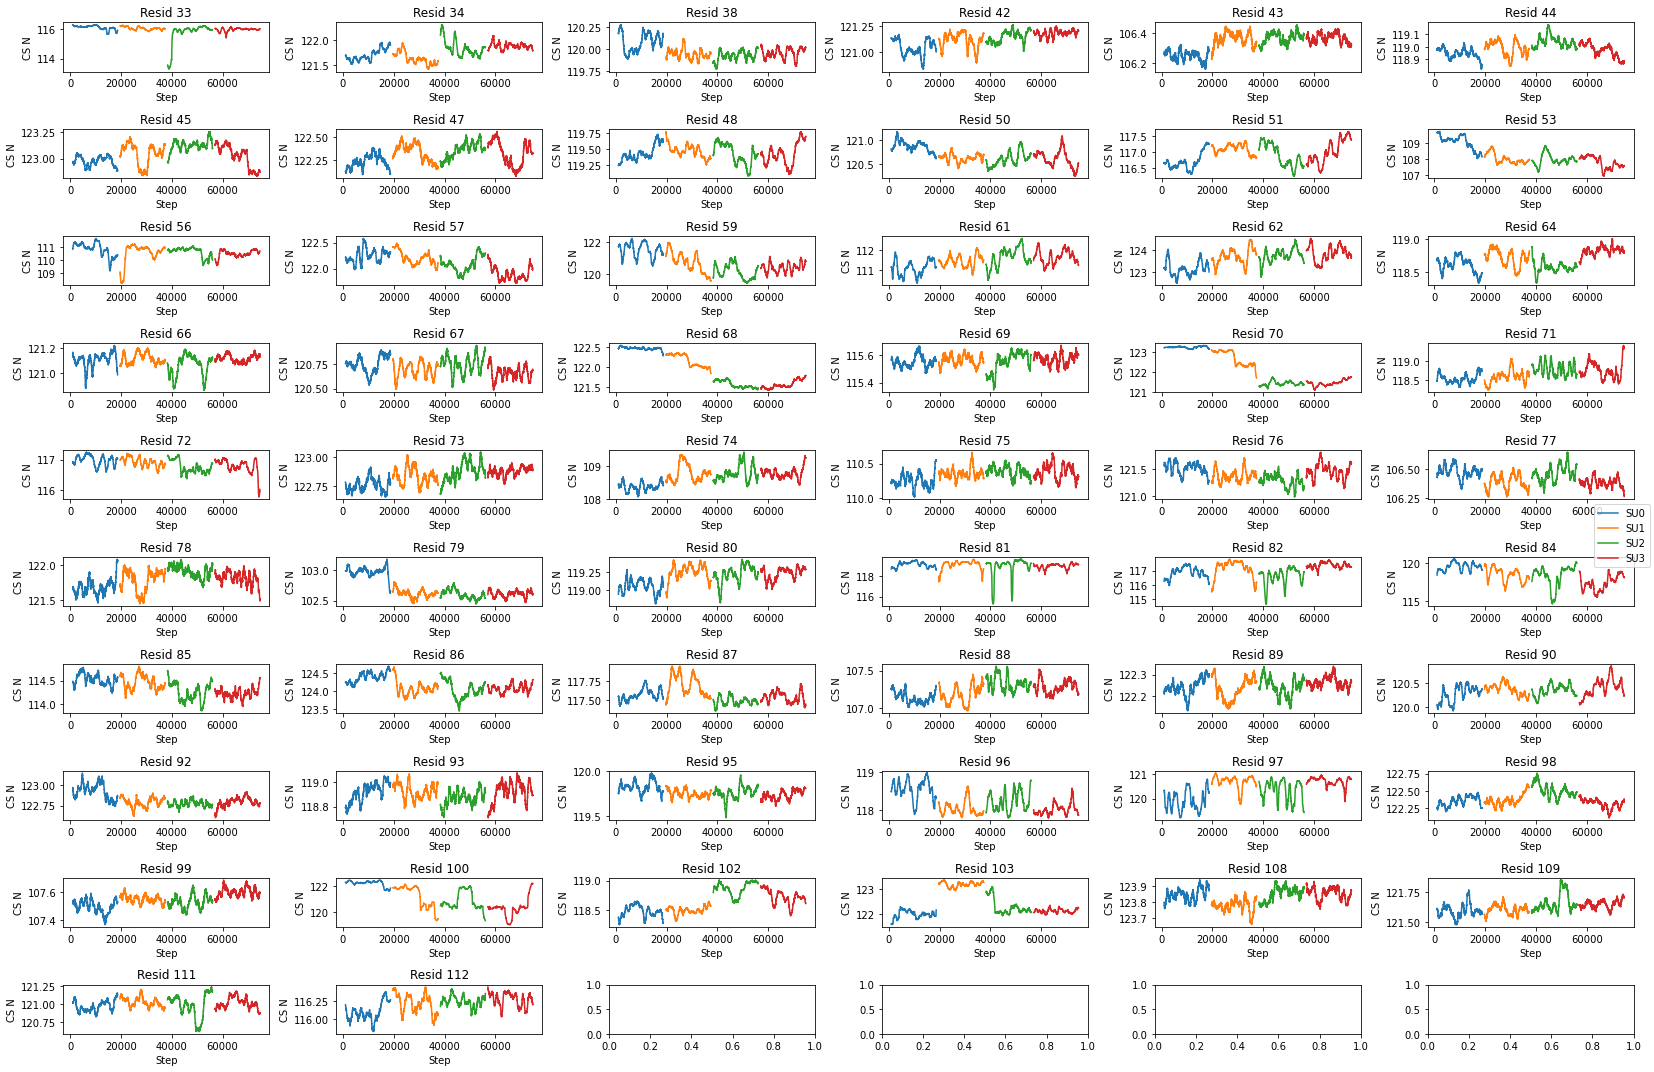

In [19]:
state = '5VKH_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Open

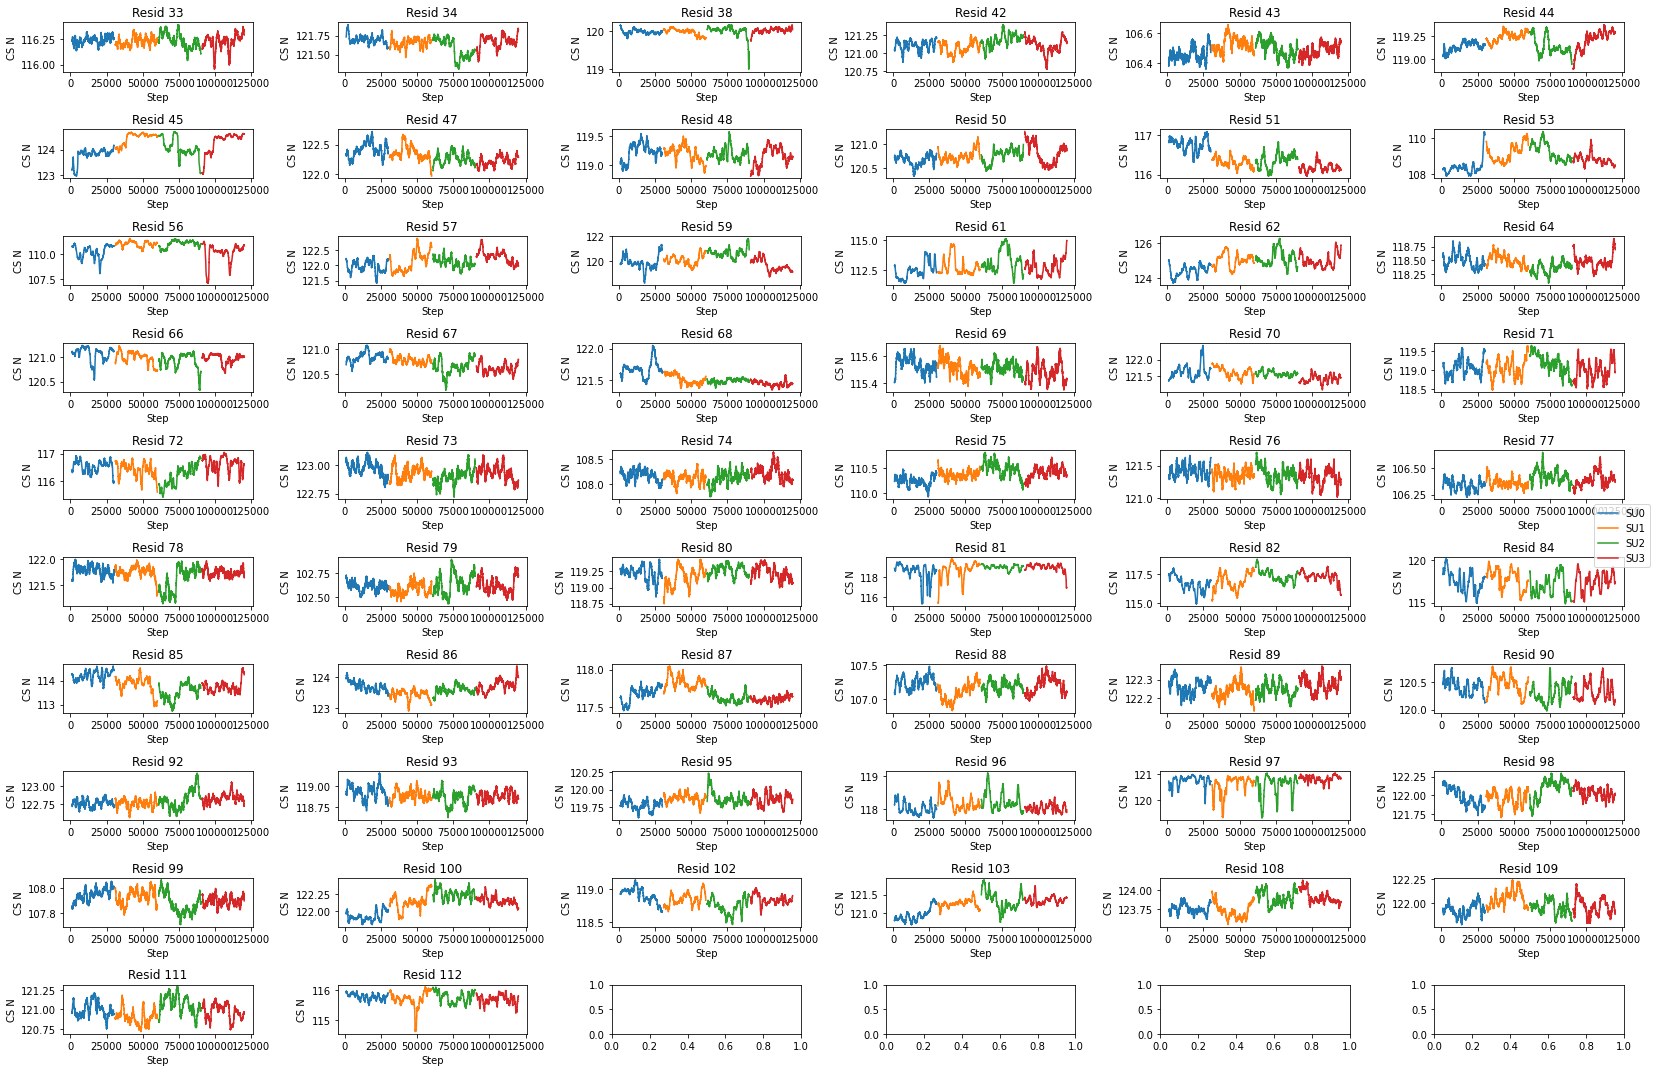

In [20]:
state = '3FB5_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

#### Fully Open

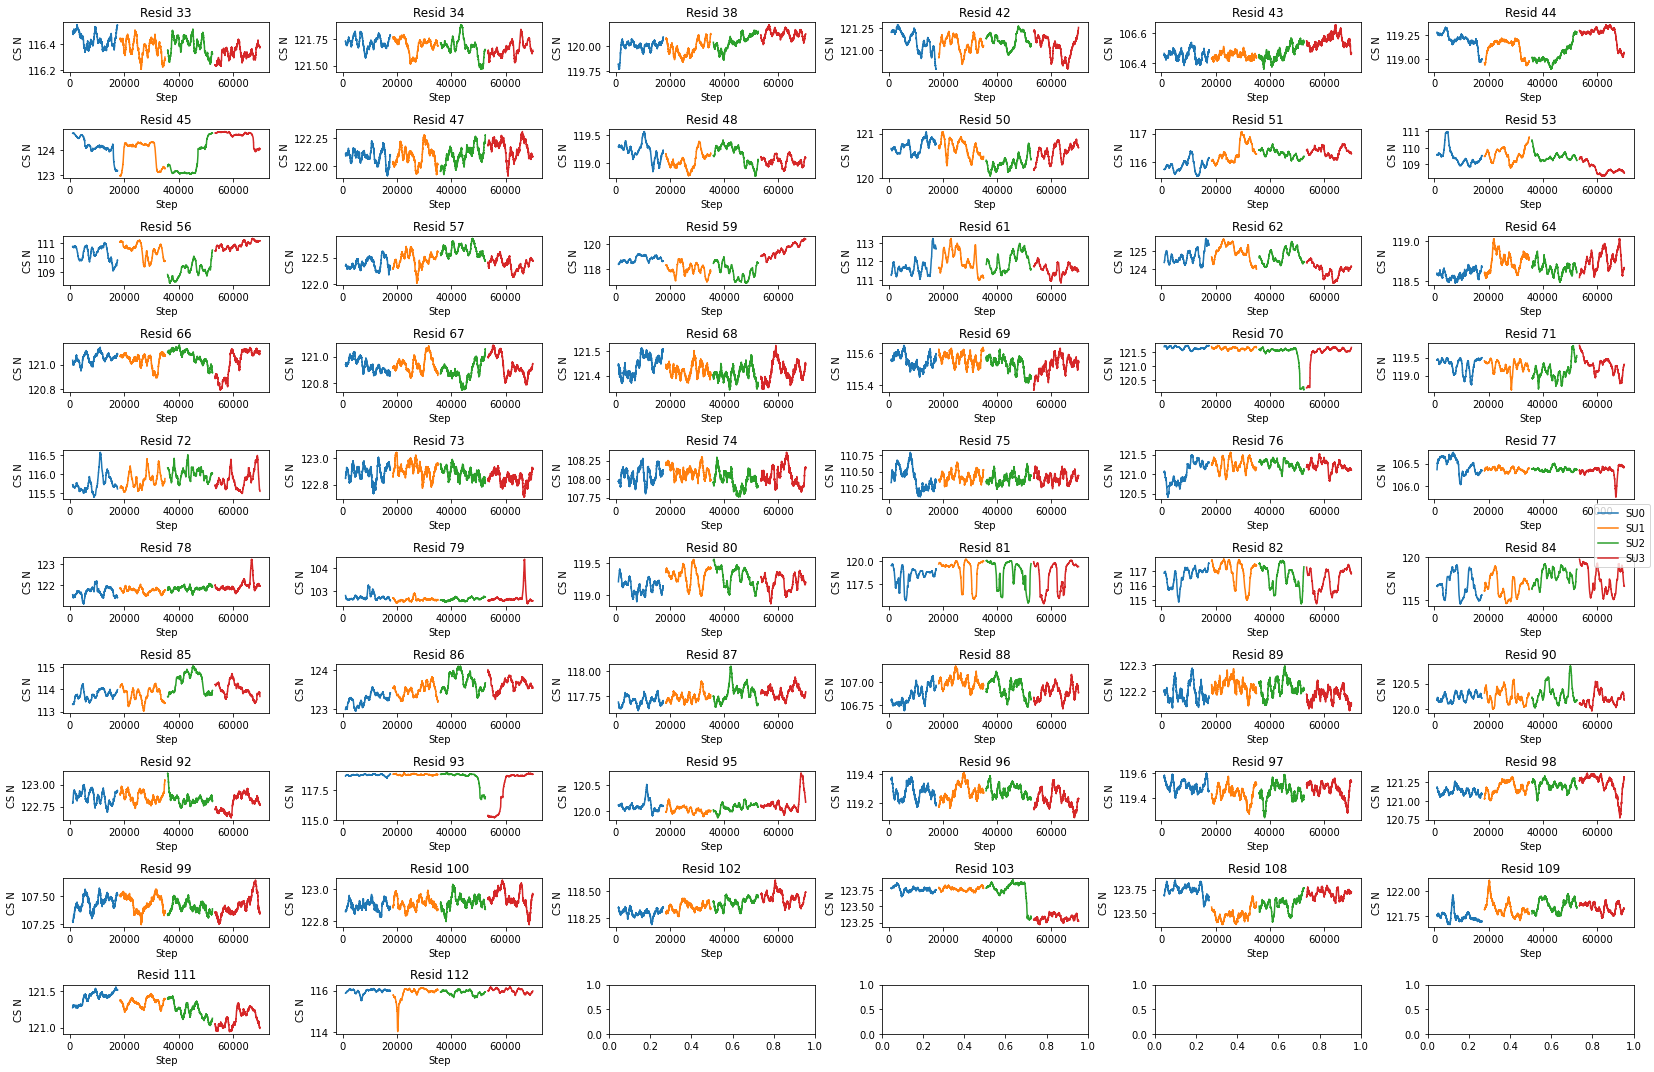

In [21]:
state = '5VK6_lb'
df = pd.read_pickle(f'{processed_data_dir}{state}/CS_{method}_{state}.pkl')
df = df.loc[:, mask].xs(nucleus, level='nuclei', axis=1)
n_roll = 1000
fig, ax = plt.subplots(df.shape[1] // 6 + 1, 6, figsize=(23, 15))
ax = ax.flatten()
for i, resid in enumerate(df):
    for j, split in enumerate(np.split(df[resid], 4)):
        y = split.rolling(n_roll).median()[n_roll:]
        ax[i].plot(y, label=f'SU{j}')
    ax[i].set_title(f'Resid {resid}')
    ax[i].set_ylabel(f'CS {nucleus}')
    ax[i].set_xlabel('Step')
handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.savefig(reports_dir + f'time_series_{method}_{nucleus}_{state}.png')
del df

## Model Data

In [22]:
def skew_mean(mu, sig, alpha):
    mean = mu + sig * np.sqrt(2. / np.pi) * alpha / np.sqrt(1 + alpha * alpha)
    return mean

In [23]:
def skew_std(sig, alpha):
    std = np.sqrt(sig * sig * (1 - 2 * alpha * alpha / (alpha * alpha + 1) / np.pi))
    return std

In [24]:
if model_name == 'skew_model':
    beta_prior = 10
    alpha_prior = 10
    sd_prior = 10
    diff_vector = df_diff.to_numpy().T
    with pm.Model(coords=coords) as my_model:
        mu_o = pm.Normal('mu_o', mu=df_3fb5.mean(), sd=sd_prior, dims='resid')
        sd_o = pm.HalfCauchy('sd_o', beta=beta_prior, dims='resid')
        alpha_o = pm.Normal('alpha_o', mu=0, sd=alpha_prior, dims='resid')
        mu_fo = pm.Normal('mu_fo', mu=df_5vk6.mean(), sd=sd_prior, dims='resid')
        sd_fo = pm.HalfCauchy('sd_fo', beta=beta_prior, dims='resid')
        alpha_fo = pm.Normal('alpha_fo', mu=0, sd=alpha_prior, dims='resid')
        mu_c = pm.Normal('mu_c', mu=df_5vkh.mean(), sd=sd_prior, dims='resid')
        sd_c = pm.HalfCauchy('sd_c', beta=beta_prior, dims='resid')
        alpha_c = pm.Normal('alpha_c', mu=0, sd=alpha_prior, dims='resid')

        # Define the likelihood.
        like_o = pm.SkewNormal('like_o',
                           mu=mu_o,
                           sd=sd_o,
                           alpha=alpha_o,
                           observed=df_3fb5,
                           dims=('step', 'resid')
                           )
        like_c = pm.SkewNormal('like_c',
                           mu=mu_c,
                           sd=sd_c,
                           alpha=alpha_c,
                           observed=df_5vkh,
                           dims=('step', 'resid')
                           )
        like_fo = pm.SkewNormal('like_fo',
                           mu=mu_fo,
                           sd=sd_fo,
                           alpha=alpha_fo,
                           observed=df_5vk6,
                           dims=('step', 'resid')
                           )
        mean_o = pm.Deterministic('mean_o', skew_mean(mu_o, sd_o, alpha_o), dims='resid')
        mean_fo = pm.Deterministic('mean_fo', skew_mean(mu_fo, sd_fo, alpha_fo), dims='resid')
        mean_c = pm.Deterministic('mean_c', skew_mean(mu_c, sd_c, alpha_c), dims='resid')
        std_o = skew_std(sd_o, alpha_o)
        std_fo = skew_std(sd_fo, alpha_fo)
        std_c = skew_std(sd_c, alpha_c)
        diff_means = pm.Deterministic('diff_means', mean_o - mean_fo, dims='resid')
        mean_o_c = pm.Deterministic('mean_o_c', mean_o - mean_c, dims='resid') - diff_vector
        mean_fo_c = pm.Deterministic('mean_fo_c', mean_fo - mean_c, dims='resid') - diff_vector
        pooled_sd = np.sqrt(np.power(std_o, 2) + np.power(std_fo, 2) / (2))
        effect_size = pm.Deterministic('effect_size',
                                       diff_means / pooled_sd, dims='resid')
    model_path = models_dir + f"{model_name}_{method}_{nucleus}.nc"

In [25]:
%%time
%%ding
if infer:
    with my_model:
        my_model_trace = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED, return_inferencedata=False)
        ppc = pm.sample_posterior_predictive(my_model_trace, var_names=["like_fo","like_o","like_c"], random_seed=RANDOM_SEED)
    my_model_trace = az.from_pymc3(trace=my_model_trace, model=my_model, posterior_predictive=ppc)
    print('Done infering.')
    spc_os.remove(model_path)
    my_model_trace.to_netcdf(model_path)
    print('Done saving.')
    del ppc

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_c, sd_c, mu_c, alpha_fo, sd_fo, mu_fo, alpha_o, sd_o, mu_o]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12416 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Done infering.
Didn't remove anything
Done saving.
CPU times: user 17min 44s, sys: 40.5 s, total: 18min 25s
Wall time: 3h 44min 40s


## Critize model 

In [26]:
my_model_trace = az.from_netcdf(model_path)

In [27]:
spc_os.mkdir(reports_dir + f'critique/{model_name}_{method}_{nucleus}')

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [28]:
if critique:
    df_summary = az.summary(my_model_trace)
    with pd.option_context('display.max_rows', None):
        print(df_summary)

                    mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_o[0]          116.845  0.029  116.788  116.897      0.000    0.000   
mu_o[1]          122.217  0.026  122.169  122.268      0.000    0.000   
mu_o[2]          120.701  0.028  120.649  120.755      0.000    0.000   
mu_o[3]          121.187  0.242  120.796  121.576      0.004    0.003   
mu_o[4]          106.915  0.119  106.742  107.084      0.003    0.002   
mu_o[5]          119.716  0.031  119.657  119.775      0.000    0.000   
mu_o[6]          125.152  0.022  125.109  125.192      0.000    0.000   
mu_o[7]          122.633  0.312  122.007  123.044      0.006    0.004   
mu_o[8]          119.947  0.031  119.886  120.003      0.000    0.000   
mu_o[9]          121.190  0.247  120.622  121.503      0.006    0.004   
mu_o[10]         115.455  0.051  115.358  115.549      0.001    0.000   
mu_o[11]         107.455  0.150  107.186  107.737      0.002    0.001   
mu_o[12]         112.621  0.077  112.470  112.762  

### Plot Traces (Posteriors)

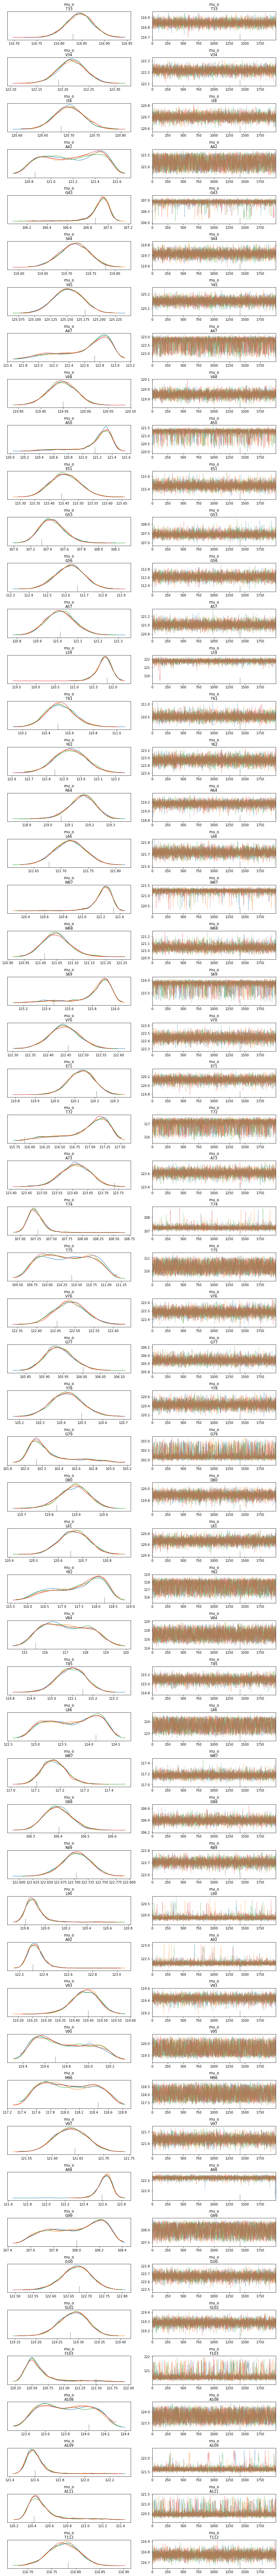

In [29]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': df_3fb5.shape[1] * 2}):
        az.plot_trace(my_model_trace, var_names=[magnitude])
    plt.savefig(reports_dir + f'critique/{model_name}_{method}_{nucleus}/trace_{magnitude}.png')

### Autocorrelations

In [ ]:
if critique:
    magnitude = 'mu_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'mu_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'sd_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_o'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_fo'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

In [ ]:
if critique:
    magnitude = 'alpha_c'
    with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_autocorr(my_model_trace, combined=True, var_names=[magnitude])
    plt.savefig(
        f'{reports_dir}critique/{model_name}_{method}_{nucleus}/autocorr_{magnitude}.png')

### Posterior Predictive Test

### PPC Open

In [ ]:
if critique:
    state = 'o'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Fully Open

In [ ]:
if critique:
    state = 'fo'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

### PPC Closed

In [ ]:
if critique:
    state = 'c'
    az.plot_ppc(my_model_trace, flatten=['step'], var_names = [f'like_{state}'], random_seed=RANDOM_SEED)
    plt.savefig(f'{reports_dir}critique/{model_name}_{method}_{nucleus}/ppc_{state}.png')

## Investigate

In [ ]:
my_model = az.from_netcdf(model_path)

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['alpha_o', 'alpha_fo', 'alpha_c'], 'alpha', 'state',
    ['o', 'fo', 'c'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o_c', 'mean_fo_c'], 'mean_ref', 'state',
    ['o', 'fo'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mean_o', 'mean_fo', 'mean_c'], 'mean', 'state',
    ['o', 'fo', 'c'])

### Is it Skewed?

In [ ]:
%%ding
variable = 'alpha'
az.plot_forest((my_model.sel(state="o"), 
                my_model.sel(state="fo"),
                my_model.sel(state="c")),
               var_names=variable,
               combined=True,
               colors=["C0", "C1","C2"],
               model_names=["o", "fo","c"],
               textsize=9,
               figsize=(7, 15))
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/{variable}_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()

### Difference in CS

In [ ]:
%%ding
az.plot_forest(
    (my_model.sel(state="o"), my_model.sel(state="fo")),
    var_names="mean",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    textsize=9,
    figsize=(7, 15),
)
plt.xlabel(f'{nucleus} ppm')
plt.savefig(f'{reports_dir}figures/mu_{model_name}_{method}_{nucleus}.png')
plt.tight_layout()

### Which signals are statistically different in o/fo

In [ ]:
az.plot_forest(my_model.posterior, rope=(-0.2, 0.2), combined=True,
              var_names=['diff_means'])
plt.xlabel(f'mean_fo-mean_o {nucleus} (ppm)')
plt.savefig(f'{reports_dir}figures/diff_mu_{model_name}_{method}_{nucleus}.png')

In [ ]:
az.plot_forest(my_model, combined=True, var_names=['effect_size'], rope=(-0.5, 0.5))
plt.xlabel(f'Effect size {nucleus}')
plt.savefig(f'{reports_dir}figures/effect_size_{model_name}_{method}_{nucleus}.png')

### Assignment

CA

sparta_plus

In [ ]:
studied_res = ['A50', 'T61', 'R64', 'T75', 'S102', 'T107']

In [ ]:
print(get_significant( models_dir + f"{model_name}_sparta_plus_CA.nc"))

ppm

In [ ]:
print(get_significant( models_dir + f"{model_name}_ppm_CA.nc"))

In [ ]:
print(get_significant( models_dir + f"{model_name}_ppm_CA.nc"))

In [ ]:
studied_res = ['Y62', 'R64', 'Y78', 'G99', 'S102', 'T107']

shiftx2

In [ ]:
studied_res = [ 'G56', 'T61', 'M96', 'G99', 'T107' ]

In [ ]:
print(get_significant( models_dir + f"{model_name}_shiftx2_CA.nc"))

N

sparta_plus

In [ ]:
studied_res = ['L59', 'M96', 'G99', 'I100', 'S102', 'F103']

In [ ]:
print(get_significant( models_dir + f"{model_name}_sparta_plus_N.nc"))

ppm

In [ ]:
studied_res = ['L59', 'Y78', 'M96', 'I100', 'S102', 'F103', 'A108']

In [ ]:
print(get_significant( models_dir + f"{model_name}_ppm_N.nc"))

shiftx2

In [ ]:
studied_res = [ 'L59', 'Y62', 'M96', 'V97', 'G99', 'S102', 'F103' ]

In [ ]:
print(get_significant( models_dir + f"{model_name}_shiftx2_N.nc"))

C

sparta_plus

In [ ]:
studied_res = []

In [ ]:
print(get_significant( models_dir + f"{model_name}_sparta_plus_C.nc"))

ppm

In [ ]:
print(get_significant( models_dir + f"{model_name}_ppm_C.nc"))

In [ ]:
studied_res = ['Y62', 'Y78']

shiftx2

In [ ]:
studied_res = [ 'A50' ]

In [ ]:
print(get_significant( models_dir + f"{model_name}_shiftx2_C.nc"))

CB

sparta_plus

In [ ]:
studied_res = [ 'I60', 'T61', 'Y62']

In [ ]:
print(get_significant( models_dir + f"{model_name}_sparta_plus_CB.nc"))

ppm

In [ ]:
print(get_significant( models_dir + f"{model_name}_ppm_CB.nc"))

In [ ]:
studied_res = ['E51', 'Y62', 'Y78', 'M96', 'A98', 'S102', 'A111']

shiftx2

In [ ]:
studied_res = [ 'I60', 'T61', 'Y78', 'M96', 'A98', 'S102' ]

In [ ]:
print(get_significant( models_dir + f"{model_name}_shiftx2_CB.nc"))

In [ ]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mean_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_{model_name}_{method}_{nucleus}.png')

All

In [ ]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="mean_ref",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    #coords={'resid': studied_res}
)
plt.xlabel(f'mu_o/fo-mu_c-(exp_X-exp_c) {nucleus} ppm')
plt.savefig(f'{reports_dir}figures/assignment_all_{model_name}_{method}_{nucleus}.png')

## Print Quality Figures

In [ ]:
my_model = az.from_netcdf(model_path)

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o', 'mu_fo', 'mu_c'], 'mu', 'state',
    ['o', 'fo', 'c'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['sd_o', 'sd_fo', 'sd_c'], 'sd', 'state',
    ['o', 'fo', 'c'])

In [ ]:
my_model.posterior = combine_posterior_variables(
    my_model.posterior, ['mu_o_c', 'mu_fo_c'], r'$\Delta$CS$_{theo}$', 'state',
    ['o', 'fo'])

In [ ]:
az.plot_forest(
    (my_model.posterior.sel(state="o"), my_model.posterior.sel(state="fo")),
    var_names="$\Delta$CS$_{theo}$",
    combined=True,
    colors=["C0", "C1"],
    model_names=["o", "fo"],
    rope=(-0.2, 0.2),
    coords={'resid': studied_res}
)
plt.xlabel(r'$\Delta$CS$_{theo}$-$\Delta$CS$_{exp}$  (ppm)',size=15)
plt.title(r'C$_\alpha$ Chemical Shifts', size=20)
plt.xlim([-1.3,1])
plt.savefig(f'{reports_dir}figures/assignment_{model_name}_{method}_{nucleus}_print.svg')